In [1]:
import zipfile

with zipfile.ZipFile('./../data/earth_day_missions.csv.zip', 'r') as myzip:
    myzip.extract('earth_day_missions.csv', './../data/')
    myzip.close()

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./../data/earth_day_missions.csv', index_col=0, low_memory=False)
df = df[~df['ignored']]
df = df[['start_date', 'user', 'missionId', 'missionType', 'missionSubType', 'period', 'target', 'title', 'satisfied']]

df['start_date'] = pd.to_datetime(df['start_date'])
df['user'] = df['user'].astype('category').cat.codes
df['missionId'] = df['missionId'].astype('category').cat.codes
df['missionType'] = df['missionType'].astype('category')
df['missionSubType'] = df['missionSubType'].astype('category')
df['period'] = df['period'].astype('category')

df = df.sort_values(by=['start_date'], ignore_index=True)

df

,start_date,user,missionId,missionType,missionSubType,period,target,title,satisfied
0,2024-03-25,21190,30,TICKET,TICKET,CUSTOM,1,ticket,True
1,2024-03-25,18882,30,TICKET,TICKET,CUSTOM,1,ticket,True
2,2024-03-25,17304,14,MEASURE,TYPEFORM_BASE,CUSTOM,1,calculate_carbon_footprint,True
3,2024-03-25,17304,16,LEARN,JOURNEY,CUSTOM,1,complete_journey,True
4,2024-03-25,17304,30,TICKET,TICKET,CUSTOM,1,ticket,True
...,...,...,...,...,...,...,...,...,...
45115,2024-04-20,8951,28,LEARN,DAILYEPISODE,DAILY,1,watch_the_daily_episode,True
45116,2024-04-20,8951,32,CHECKIN,CHECKIN,DAILY,1,do_checkin,True
45117,2024-04-20,22776,3,CHECKIN,CHECKIN,DAILY,1,do_checkin,True
45118,2024-04-20,19837,28,LEARN,DAILYEPISODE,DAILY,1,watch_the_daily_episode,True


In [3]:
summary = df.groupby(['missionId', 'title', 'missionType', 'missionSubType', 'period', 'target', 'satisfied'], observed=True).size().unstack(fill_value=0)
summary.sort_index(level=[2, 3, 4, 5], inplace=True)

summary

,,,,,satisfied,False,True
missionId,title,missionType,missionSubType,period,target,,
8,log_1_action,ACT,ALL,DAILY,1,0,636
24,log_2_action,ACT,ALL,DAILY,2,113,1087
18,log_3_action,ACT,ALL,DAILY,3,115,517
33,log_2_action2_consecutive,ACT,ALL,WEEKLY,2,1425,190
25,log_1_action_energy,ACT,ENERGY,DAILY,1,0,101
21,log_2_action_energy,ACT,ENERGY,DAILY,2,48,814
26,log_1_action_environment,ACT,ENVIRONMENT,DAILY,1,0,554
11,log_1_action_vegetarian,ACT,FIXED,DAILY,1,0,98
31,log_action_take5minutesshower,ACT,FIXED,DAILY,1,0,101


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LogisticRegression(nn.Module):
    def __init__(self, num_users, num_items) -> None:
        super().__init__()

        self.user = nn.Embedding(num_users, 1)
        self.item = nn.Embedding(num_items, 1)
        self.bias = nn.Parameter(torch.zeros(1))
        self.output = nn.Sigmoid()

    def forward(self, user_id, item_id):
        user = self.user(user_id)
        item = self.item(item_id)
        x = user + item + self.bias
        x = self.output(x)
        return x.view(-1)
    
    def fit(self, data_loader: DataLoader, num_epochs):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.01)

        for _ in (t := tqdm(range(num_epochs))):
            self.train()
            total_loss = 0

            for d in (b := tqdm(data_loader, leave=False)):
                d = d.to(DEVICE)
                user = d[:, 0]
                item = d[:, 1]
                target = d[:, 2].float()

                optimizer.zero_grad()
                output = self(user, item)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                b.set_postfix(loss=loss.item())

            t.set_postfix(loss=total_loss / len(data_loader))
    

class LogisticRegressionDataset(Dataset):
    def __init__(self, data) -> None:
        super().__init__()

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row: pd.Series = self.data.iloc[idx]
        row = torch.from_numpy(row.to_numpy()).long()
        return row


In [5]:
dataset = df[['user', 'missionId', 'satisfied']] \
    .drop_duplicates(subset=['user', 'missionId'], keep='last') \
    .astype(int) \
    .reset_index(drop=True)

dataset

,user,missionId,satisfied
0,21190,30,1
1,18882,30,1
2,17304,14,1
3,17304,16,1
4,17304,30,1
...,...,...,...
41771,8951,28,1
41772,8951,32,1
41773,22776,3,1
41774,19837,28,1


In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for train_index, test_index in skf.split(np.zeros(len(dataset)), dataset['satisfied']):
    train_dataset = LogisticRegressionDataset(dataset.loc[train_index, ['user', 'missionId', 'satisfied']])
    test_tensor = torch.from_numpy(dataset.loc[test_index, ['user', 'missionId']].to_numpy()).long().to(DEVICE)

    lr = LogisticRegression(dataset['user'].nunique(), dataset['missionId'].nunique()).to(DEVICE)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    lr.fit(train_loader, 5)

    lr.eval()
    with torch.no_grad():
        output = lr(test_tensor[:, 0], test_tensor[:, 1]).cpu().numpy()
    
    dataset.loc[test_index, 'prediction'] = output
    
    all_ones = np.ones_like(output)
    fpr, tpr, _ = roc_curve(dataset.loc[test_index, 'satisfied'], dataset.loc[test_index, 'prediction'])
    fpr_baseline, tpr_baseline, _ = roc_curve(dataset.loc[test_index, 'satisfied'], all_ones)

    precision, recall, _ = precision_recall_curve(dataset.loc[test_index, 'satisfied'], dataset.loc[test_index, 'prediction'])
    precision_baseline, recall_baseline, _ = precision_recall_curve(dataset.loc[test_index, 'satisfied'], all_ones)

    metrics.append({
        'roc_auc': auc(fpr, tpr),
        'roc_auc_baseline': auc(fpr_baseline, tpr_baseline),
        'pr_auc': auc(recall, precision),
        'pr_auc_baseline': auc(recall_baseline, precision_baseline),
    })

metrics = pd.DataFrame(metrics)
metrics.round(4)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

,roc_auc,roc_auc_baseline,pr_auc,pr_auc_baseline
0,0.9925,0.5,0.9993,0.9579
1,0.9928,0.5,0.9993,0.9579
2,0.9927,0.5,0.9993,0.9579
3,0.9934,0.5,0.9994,0.9579
4,0.9923,0.5,0.9993,0.9579


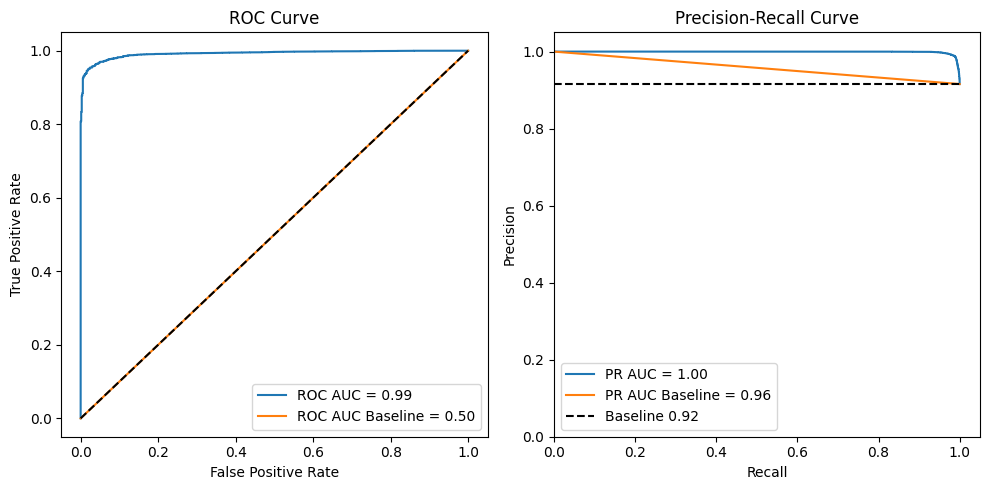

In [7]:
from matplotlib import pyplot as plt

roc_auc = metrics['roc_auc'].mean()
pr_auc = metrics['pr_auc'].mean()

roc_auc_baseline = metrics['roc_auc_baseline'].mean()
pr_auc_baseline = metrics['pr_auc_baseline'].mean()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot(fpr_baseline, tpr_baseline, label=f'ROC AUC Baseline = {roc_auc_baseline:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.plot(recall_baseline, precision_baseline, label=f'PR AUC Baseline = {pr_auc_baseline:.2f}')
plt.hlines(y=dataset['satisfied'].mean(), xmin=0, xmax=1, linestyles='dashed', colors='black', label=f'Baseline {dataset["satisfied"].mean():.2f}')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()